In [2]:
import json
import pandas as pd

# Adjust this path if needed
PATH = "/shared_folders/team_1/ben/10000_summaries.json"

# The file is a dict of {doc_id: {file_path, summary}}
with open(PATH, "r") as f:
    raw = json.load(f)

# Turn it into a table
rows = []
for doc_id, rec in raw.items():
    rows.append({
        "doc_id": doc_id,
        "file_path": rec["file_path"],
        "summary": rec["summary"]
    })
df = pd.DataFrame(rows)


         word_count    char_count
count   9746.000000   9746.000000
mean     130.022471    934.036323
std      307.507562   2058.787670
min        1.000000     14.000000
25%       84.000000    597.000000
50%      105.000000    762.000000
75%      134.000000    971.750000
max    13896.000000  95251.000000


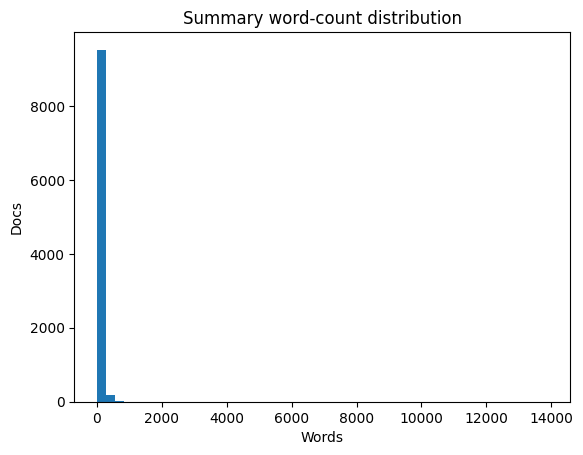

In [3]:
# length in words & chars
df["word_count"] = df.summary.str.split().str.len()
df["char_count"] = df.summary.str.len()

# Quick stats
print(df[["word_count","char_count"]].describe())

# Visualize
import matplotlib.pyplot as plt

plt.hist(df.word_count, bins=50)
plt.title("Summary word‐count distribution")
plt.xlabel("Words")
plt.ylabel("Docs")
plt.show()


In [ ]:
KEYWORDS = ["catalyst","reactor","reaction","mechanism"]
for k in KEYWORDS:
    df[k] = df.summary.str.lower().str.contains(k)

coverage = df[KEYWORDS].mean().mul(100).round(1)
print("Keyword coverage (%) per term:\n", coverage)


/home/jonathan_morse/miniconda3/envs/ragui_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Batches: 100%|██████████| 305/305 [00:23<00:00, 13.23it/s]


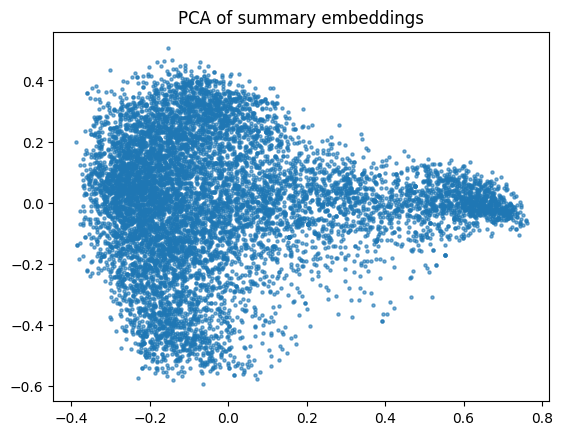

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(df.summary.tolist(), show_progress_bar=True)

# Project down for plotting
pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings)

plt.scatter(coords[:,0], coords[:,1], s=5, alpha=0.6)
plt.title("PCA of summary embeddings")
plt.show()


In [ ]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# 1. Load your summaries
PATH = "/shared_folders/team_1/ben/10000_summaries.json"
with open(PATH, "r") as f:
    raw = json.load(f)

# 2. Build a DataFrame and extract the first sentence
rows = []
for doc_id, rec in raw.items():
    summary = rec["summary"].strip()
    first_sentence = summary.split(".", 1)[0] + ("."
        if "." in summary else "")
    rows.append({
        "doc_id": doc_id,
        "file_path": rec["file_path"],
        "first_sentence": first_sentence
    })
df = pd.DataFrame(rows)

# 3. Vectorize first sentences with TF-IDF
vec = TfidfVectorizer(max_features=500)
X = vec.fit_transform(df["first_sentence"])

# 4. Cluster with K-Means
k = 5
km = KMeans(n_clusters=k, random_state=42)
df["cluster"] = km.fit_predict(X)

# 5. Reduce to 2D for plotting
svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(X)

# 6. Plot
plt.figure()
plt.scatter(coords[:,0], coords[:,1], c=df["cluster"], alpha=0.6)
plt.title("Clusters of First Sentences")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# 7. Inspect a few examples per cluster
for c in range(k):
    print(f"\nCluster {c} sample:")
    print(df[df["cluster"] == c].first_sentence.head(3).to_list())


In [ ]:
pip install nbformat

In [1]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio

# ─── 1) Load your summaries ───────────────────────────────────────────────────
PATH = "/shared_folders/team_1/ben/10000_summaries.json"  # adjust as needed
with open(PATH, "r") as f:
    raw = json.load(f)

# ─── 2) Build DataFrame & extract first sentence ─────────────────────────────
rows = []
for doc_id, rec in raw.items():
    summary = rec["summary"].strip()
    first_sentence = summary.split(".", 1)[0] + ("." if "." in summary else "")
    rows.append({"doc_id": doc_id, "first_sentence": first_sentence})
df = pd.DataFrame(rows)

# ─── 3) TF-IDF vectorize ───────────────────────────────────────────────────────
vec = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = vec.fit_transform(df["first_sentence"])

# ─── 4) K-Means clustering ────────────────────────────────────────────────────
k = 10
km = KMeans(n_clusters=k, random_state=42)
df["cluster"] = km.fit_predict(X)

# ─── 5) Print first 10 examples per cluster ──────────────────────────────────
for cluster_id, group in df.groupby("cluster"):
    print(f"\nCluster {cluster_id} (first {min(10, len(group))} docs):")
    for idx, row in group.head(10).iterrows():
        print(f" - [{row['doc_id']}] {row['first_sentence']}")

# ─── 6) 3D PCA projection & interactive plot ─────────────────────────────────
pca3 = PCA(n_components=3, random_state=42)
coords3 = pca3.fit_transform(X.toarray())
df[["PC1", "PC2", "PC3"]] = coords3

fig = px.scatter_3d(
    df,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    hover_data=["doc_id", "first_sentence"],
    title="Interactive 3D PCA of First-Sentence Clusters"
)
fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3")
)
pio.renderers.default = "browser"
fig.show()



Cluster 0 (first 10 docs):
 - [5] This document is a controlled copy of "0175-SWT-A2-AA0-910-General Notes and Symbols.
 - [6] This controlled copy of a final clarification TK-470 PDF file, printed on August 27, 2013, at 15:42:58 EDT, is titled 0175-SWT-A2-AA0-035-Final Clarifier TK-470.
 - [7] This document is a controlled copy of a biological reactor specification PDF file, dated August 27, 2013, with an expiration on August 28, 2013.
 - [8] This document is a controlled copy of a sampling plan for Northwest Waste Master, labeled "Sampling" in the file name.
 - [32] This document, titled "ORDENETH," is a technical draft file named "0175-SWT-A2-AA0-061-Scrubber-Induced Draft Blowers.
 - [98] This document is a controlled copy of "Potable Water System (4.
 - [99] This document is a controlled copy of an animation file titled "432 Potable Water Distribution MN B 2 & Aniline Line 2(1.
 - [142] This document is a file listing, specifically referencing "w2ab6601.
 - [155] This document is

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(2, 16)
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(km.inertia_)

plt.plot(K, inertias, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    labels = km.labels_
    scores.append(silhouette_score(X, labels))

plt.plot(K, scores, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Average silhouette score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()
